In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 113.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment").to(device)

In [ ]:
import urllib
import csv
labels=[]
task = 'sentiment'
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

In [ ]:
# Import Data
data = pd.read_excel('data siap olah.xlsx', 'Sheet2')
data

,Tweet,sentiment
0,stewart tragic see civilian target russian tro...,negative
1,say earlier map valuable inform russian troop ...,negative
2,usa britain invade country like evil russia ir...,negative
3,thank worker israel ben union airport friday s...,positive
4,play katrina gravel pain standwithukrain,negative
...,...,...
11551,soon think russia could invade,neutral
11552,nation secure advisor sullivan say schedule ta...,negative
11553,matter matter russia decide invade ukraine dec...,negative
11554,wait russia might actual invade ukraine,neutral


In [ ]:
from scipy.special import softmax
BATCH_SIZE = 1000

scores_all = np.empty((0,len(labels)))
text_all = data['Tweet'].to_list()
n = len(text_all)
with torch.no_grad():
    for start_idx in range(0, n, BATCH_SIZE):
        end_idx = min(start_idx+BATCH_SIZE, n)
        encoded_input = tokenizer(text_all[start_idx:end_idx], return_tensors='pt', padding=True, truncation=True).to(device)
        output = model(**encoded_input)
        scores = output[0].detach().cpu().numpy()
        scores = softmax(scores, axis=1)
        scores_all = np.concatenate((scores_all, scores), axis=0)
        del encoded_input, output, scores
        torch.cuda.empty_cache()


data[labels] = pd.DataFrame(scores_all, columns=labels)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
data.to_csv("labeling_sentimen.csv", index=False)

In [ ]:
tweet_df = pd.read_csv("labeling_sentimen.csv", lineterminator='\n')
tweet_df

,Tweet,sentiment,negative,neutral,positive
0,stewart tragic see civilian target russian tro...,negative,0.898309,0.098496,0.003196
1,say earlier map valuable inform russian troop ...,negative,0.233045,0.676789,0.090166
2,usa britain invade country like evil russia ir...,negative,0.861027,0.134544,0.004429
3,thank worker israel ben union airport friday s...,positive,0.016300,0.719596,0.264104
4,play katrina gravel pain standwithukrain,negative,0.147727,0.823413,0.028860
...,...,...,...,...,...
11551,soon think russia could invade,neutral,0.493140,0.489292,0.017568
11552,nation secure advisor sullivan say schedule ta...,negative,0.317856,0.665151,0.016993
11553,matter matter russia decide invade ukraine dec...,negative,0.460420,0.518071,0.021509
11554,wait russia might actual invade ukraine,neutral,0.750045,0.242243,0.007712


In [ ]:
tweet_df.insert(5, "label", '')

In [ ]:
tweet_df

,Tweet,sentiment,negative,neutral,positive,label
0,stewart tragic see civilian target russian tro...,negative,0.898309,0.098496,0.003196,
1,say earlier map valuable inform russian troop ...,negative,0.233045,0.676789,0.090166,
2,usa britain invade country like evil russia ir...,negative,0.861027,0.134544,0.004429,
3,thank worker israel ben union airport friday s...,positive,0.016300,0.719596,0.264104,
4,play katrina gravel pain standwithukrain,negative,0.147727,0.823413,0.028860,
...,...,...,...,...,...,...
11551,soon think russia could invade,neutral,0.493140,0.489292,0.017568,
11552,nation secure advisor sullivan say schedule ta...,negative,0.317856,0.665151,0.016993,
11553,matter matter russia decide invade ukraine dec...,negative,0.460420,0.518071,0.021509,
11554,wait russia might actual invade ukraine,neutral,0.750045,0.242243,0.007712,


In [ ]:
for i in range(len(tweet_df)):
  if tweet_df['negative'][i] > tweet_df['positive'][i] and tweet_df['negative'][i] > tweet_df['neutral'][i]:
    tweet_df['label'][i] = 'negative'
  elif tweet_df['positive'][i] > tweet_df['negative'][i] and tweet_df['positive'][i] > tweet_df['neutral'][i]:
    tweet_df['label'][i]= 'positive'
  else:
    tweet_df['label'][i] = 'neutral'

<ipython-input-12-dd248f14b87e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_df['label'][i] = 'negative'
<ipython-input-12-dd248f14b87e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_df['label'][i] = 'neutral'
<ipython-input-12-dd248f14b87e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_df['label'][i]= 'positive'


In [ ]:
tweet_df

,Tweet,sentiment,negative,neutral,positive,label
0,stewart tragic see civilian target russian tro...,negative,0.898309,0.098496,0.003196,negative
1,say earlier map valuable inform russian troop ...,negative,0.233045,0.676789,0.090166,neutral
2,usa britain invade country like evil russia ir...,negative,0.861027,0.134544,0.004429,negative
3,thank worker israel ben union airport friday s...,positive,0.016300,0.719596,0.264104,neutral
4,play katrina gravel pain standwithukrain,negative,0.147727,0.823413,0.028860,neutral
...,...,...,...,...,...,...
11551,soon think russia could invade,neutral,0.493140,0.489292,0.017568,negative
11552,nation secure advisor sullivan say schedule ta...,negative,0.317856,0.665151,0.016993,neutral
11553,matter matter russia decide invade ukraine dec...,negative,0.460420,0.518071,0.021509,neutral
11554,wait russia might actual invade ukraine,neutral,0.750045,0.242243,0.007712,negative


In [ ]:
tweet_df.to_excel("labeling_sentimen_asli.xlsx", index=False)

<Axes: xlabel='label', ylabel='count'>

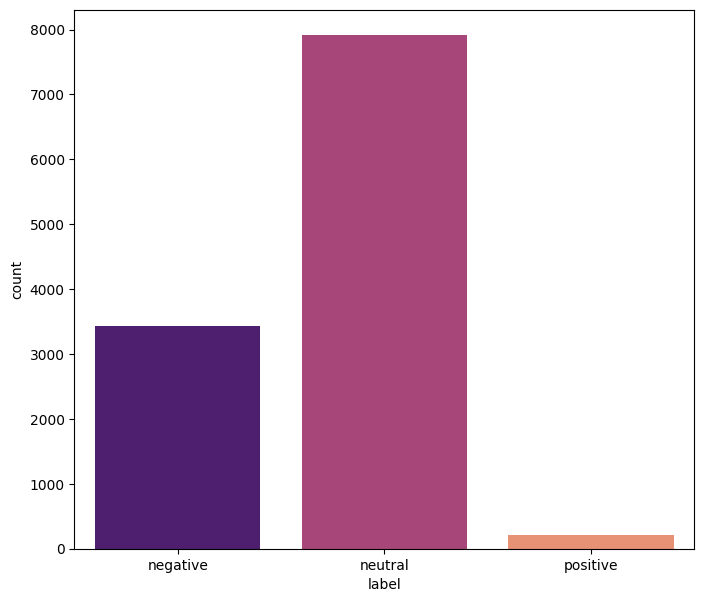

In [ ]:
plt.figure(figsize = (8,7))
sns.countplot(x="label", data=tweet_df, palette='magma')

In [ ]:
tweet_df.drop(['sentiment','negative','positive','neutral'], axis=1, inplace=True)

In [ ]:
tweet_df

,Tweet,label
0,stewart tragic see civilian target russian tro...,negative
1,say earlier map valuable inform russian troop ...,neutral
2,usa britain invade country like evil russia ir...,negative
3,thank worker israel ben union airport friday s...,neutral
4,play katrina gravel pain standwithukrain,neutral
...,...,...
11551,soon think russia could invade,negative
11552,nation secure advisor sullivan say schedule ta...,neutral
11553,matter matter russia decide invade ukraine dec...,neutral
11554,wait russia might actual invade ukraine,negative


In [ ]:
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Split data into training and testing sets
X = tweet_df['Tweet']
y = tweet_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

Vectoriser fitted.
No. of feature_words:  103860


In [ ]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [ ]:
KNNModel = KNeighborsClassifier(n_neighbors=15)
KNNModel.fit(X_train, y_train)
ys_predict = KNNModel.predict(X_test)
#Display the outcome of classification
print('Classification Report: \n',metrics.classification_report(y_test, ys_predict))
print('Confusion Matrix: \n',metrics.confusion_matrix(y_test, ys_predict))
print('Accuracy Score: \n',metrics.accuracy_score(y_test, ys_predict))

Classification Report: 
               precision    recall  f1-score   support

    negative       0.71      0.19      0.30       342
     neutral       0.72      0.97      0.83       792
    positive       0.60      0.14      0.22        22

    accuracy                           0.72      1156
   macro avg       0.68      0.43      0.45      1156
weighted avg       0.72      0.72      0.66      1156

Confusion Matrix: 
 [[ 64 278   0]
 [ 25 765   2]
 [  1  18   3]]
Accuracy Score: 
 0.7197231833910035


In [ ]:
DTCModel = DecisionTreeClassifier(random_state=42)
DTCModel.fit(X_train, y_train)
ys_predict = DTCModel.predict(X_test)
#Display the outcome of classification
print('Classification Report: \n',metrics.classification_report(y_test, ys_predict))
print('Confusion Matrix: \n',metrics.confusion_matrix(y_test, ys_predict))
print('Accuracy Score: \n',metrics.accuracy_score(y_test, ys_predict))

Classification Report: 
               precision    recall  f1-score   support

    negative       0.59      0.61      0.60       342
     neutral       0.82      0.80      0.81       792
    positive       0.48      0.73      0.58        22

    accuracy                           0.74      1156
   macro avg       0.63      0.71      0.66      1156
weighted avg       0.75      0.74      0.74      1156

Confusion Matrix: 
 [[208 132   2]
 [142 635  15]
 [  1   5  16]]
Accuracy Score: 
 0.7430795847750865


In [ ]:
RFCModel = RandomForestClassifier(n_estimators=500)
RFCModel.fit(X_train, y_train)
ys_predict = RFCModel.predict(X_test)
#Display the outcome of classification
print('Classification Report: \n',metrics.classification_report(y_test, ys_predict))
print('Confusion Matrix: \n',metrics.confusion_matrix(y_test, ys_predict))
print('Accuracy Score: \n',metrics.accuracy_score(y_test, ys_predict))

Classification Report: 
               precision    recall  f1-score   support

    negative       0.83      0.28      0.42       342
     neutral       0.74      0.97      0.84       792
    positive       0.50      0.05      0.08        22

    accuracy                           0.75      1156
   macro avg       0.69      0.43      0.45      1156
weighted avg       0.76      0.75      0.70      1156

Confusion Matrix: 
 [[ 95 247   0]
 [ 19 772   1]
 [  0  21   1]]
Accuracy Score: 
 0.7508650519031141


In [ ]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
ys_predict = LRmodel.predict(X_test)
#Display the outcome of classification
print('Classification Report: \n',metrics.classification_report(y_test, ys_predict))
print('Confusion Matrix: \n',metrics.confusion_matrix(y_test, ys_predict))
print('Accuracy Score: \n',metrics.accuracy_score(y_test, ys_predict))

Classification Report: 
               precision    recall  f1-score   support

    negative       0.76      0.53      0.63       342
     neutral       0.81      0.93      0.87       792
    positive       0.83      0.23      0.36        22

    accuracy                           0.80      1156
   macro avg       0.80      0.56      0.62      1156
weighted avg       0.80      0.80      0.79      1156

Confusion Matrix: 
 [[182 159   1]
 [ 55 737   0]
 [  1  16   5]]
Accuracy Score: 
 0.7993079584775087


In [ ]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
ys_predict = SVCmodel.predict(X_test)
#Display the outcome of classification
print('Classification Report: \n',metrics.classification_report(y_test, ys_predict))
print('Confusion Matrix: \n',metrics.confusion_matrix(y_test, ys_predict))
print('Accuracy Score: \n',metrics.accuracy_score(y_test, ys_predict))

Classification Report: 
               precision    recall  f1-score   support

    negative       0.75      0.59      0.66       342
     neutral       0.82      0.91      0.87       792
    positive       0.71      0.23      0.34        22

    accuracy                           0.81      1156
   macro avg       0.76      0.58      0.62      1156
weighted avg       0.80      0.81      0.80      1156

Confusion Matrix: 
 [[202 139   1]
 [ 67 724   1]
 [  1  16   5]]
Accuracy Score: 
 0.8053633217993079


In [ ]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
# Membuat objek LabelEncoder
label_encoder = LabelEncoder()

# Mengubah label sentimen menjadi nilai numerik
y_train_encoded = label_encoder.fit_transform(y_train)

# Membuat objek model XGBoost
xgb_model = xgb.XGBClassifier()

# Melatih model pada data training
xgb_model.fit(X_train, y_train_encoded)

# Memprediksi label pada data test
y_pred_encoded = xgb_model.predict(X_test)

# Mengembalikan label prediksi ke label asli
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Menampilkan hasil klasifikasi
print('Classification Report: \n', metrics.classification_report(y_test, y_pred))
print('Confusion Matrix: \n', metrics.confusion_matrix(y_test, y_pred))
print('Accuracy Score: \n', metrics.accuracy_score(y_test, y_pred))


Classification Report: 
               precision    recall  f1-score   support

    negative       0.80      0.46      0.58       463
     neutral       0.70      0.91      0.79       667
    positive       0.69      0.35      0.46        26

    accuracy                           0.72      1156
   macro avg       0.73      0.57      0.61      1156
weighted avg       0.74      0.72      0.70      1156

Confusion Matrix: 
 [[214 249   0]
 [ 54 609   4]
 [  1  16   9]]
Accuracy Score: 
 0.7197231833910035
